In [1]:
from LaviRot import *
import numpy as np
from scipy import linalg
from scipy.integrate import odeint
np.set_printoptions(precision=1, linewidth=300)
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import griddata
from IPython.display import clear_output



from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from itertools import permutations

In [2]:
E = 192e9
Gs = 81.2e9
rho = 7850

#propriedades do material do eixo 

In [3]:
si_d = 0
so_d = 0.145 # diametro externo do eixo

In [4]:
L = [.191/2,
     .191/2,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .090,
     .191/2,
     .191/2]

In [5]:
nelem = [x for x in range(len(L))]

In [6]:
shaft_elem = [ShaftElement(n, l, si_d, so_d, E, Gs, rho,
                           shear_effects=True,
                           rotary_inertia=True,
                           gyroscopic=True) for n, l in zip(nelem, L)]

In [7]:
# impelidores onde eles possuem um diâmetro interno igual ao externo do eixo e supondo uma densidade igual, já que ambos são de ferro
disk0 = DiskElement(8, rho, 0.067, so_d, 0.365)
disk1 = DiskElement(9, rho, 0.067, so_d, 0.365)
disk2 = DiskElement(10, rho, 0.045, so_d, 0.365)
disk3 = DiskElement(11, rho, 0.03, so_d, 0.365)
disk4 = DiskElement(12, rho, 0.03, so_d, 0.340)
disk5 = DiskElement(13, rho, 0.03, so_d, 0.340)
disk6 = DiskElement(14, rho, 0.03, so_d, 0.340)

In [8]:
speed=np.array([.1,.18,.2,.35,.88,1.4,1.8,2,5]) # vetor velociidade de rotação para interpolação de kxx e kyy 
speed=(1e4*2*np.pi/60)*speed # transformação para rad/s
kx =np.array([4e7,5e7,6e7,1e8,1.8e8,3e8,3e8,3e8,3e8]) #vetor kxx para cada item do vetor speed
ky =np.array([9e7,9e7,1e8,1.5e8,1.8e8,3e8,3e8,3e8,3e8])#vetor kyy para cada item do vetor speed
cx = 1e8*np.ones(9)# supondo um amortecimento apenas constante
#
bearing0 = BearingElement(2, kxx=kx, kyy=ky, cxx=cx,w=speed) #rolamentos 
bearing1 = BearingElement(-3, kxx=kx, kyy=kx, cxx=cx,w=speed)

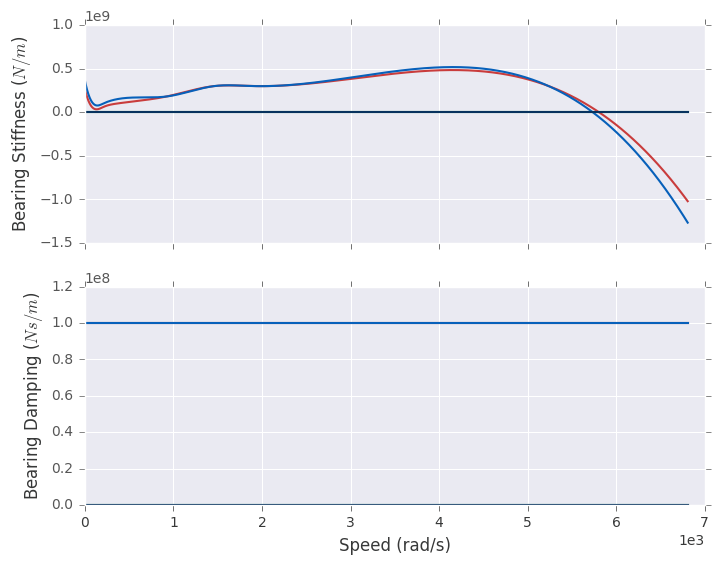

In [9]:
bearing_parameters(bearing0)

In [10]:
rotor_bal =  Rotor(shaft_elem,
                   [disk0, disk1,disk2,disk3,disk4,disk5,disk6],
                   [bearing0, bearing1])

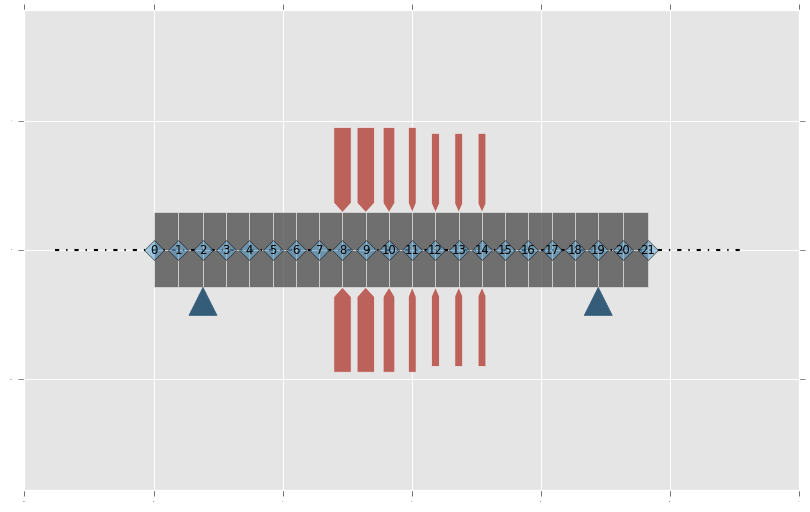

In [11]:
plot_rotor(rotor_bal)

In [12]:
speed1 = np.linspace(0, 3000, 100)

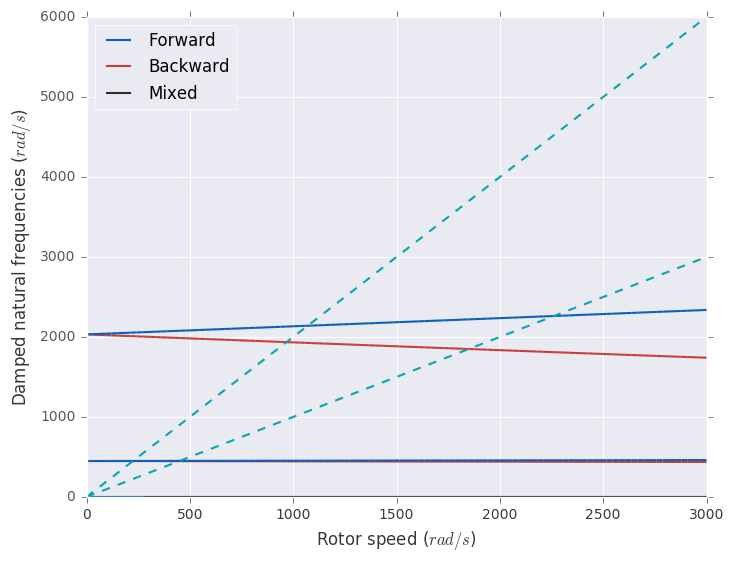

In [13]:
campbell(rotor_bal, speed1, mult=[1, 2])

In [14]:
def forcevec(): #função apenas criada para gerar um string que me ajudaria a escrever o vetor de força que será na integração do tempo
    F1=[]
    
    a=1
    b=1
    while a <= 88:
        while b <= 88:
            if a==b :
                F1=np.hstack([F1,'rotor.bal_M()[%s][%s]*dist*i^2*cos(i*t);' %(a,b)]) 
                F1=np.hstack([F1,'rotor.bal_M()[%s][%s]*dist*i^2*sin(i*t);'%(a+1,b+1)])
                F1=np.hstack([F1,'(rotor.bal_M[%s][%s]-rotor.bal_G()[%s][%s])*ang*i^2*cos(i*t);'%(a+2,b+2,a+2,b+3)])
                F1=np.hstack([F1,'(rotor.bal_M[%s][%s]-rotor.bal_G()[%s][%s])*ang*i^2*sin(i*t);'%(a+3,b+3,a+3,b+2)])
                
                b+=4
            a+=4    
            
    return F1

In [15]:
F1=forcevec()# chamando função

In [16]:
import csv # exportando o resultado da string para um arquivo de texto

res = F1
csvfile = "test.txt"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in res:
        writer.writerow([val])    

In [191]:
dist=1e-3 #desbalanceamento de 1mm
ang=0.000290888*10#desbalanceamento de 10'
i=(13003/60)*2*pi # Rotação em rad/s


M1=rotor_bal.M() #matrix massa
K1=rotor_bal.K(w=i) #matrix de elasticidade
C1=rotor_bal.C(w=i) #matrix de amortecimento
G1=rotor_bal.G() #matrix giroscopia
D=linalg.solve(M1,K1) # matrix dinamica
np.savetxt ('G_matrix', G1) 
eigvalues , eigvec = linalg.eig(D) # calculo dos autovalores e autovetores da matrix dinâmica

np.savetxt('eigvec',eigvec)
M= np.transpose(eigvec) @ M1 @ eigvec #matrix massa desacoplada
K= np.transpose(eigvec) @ K1 @ eigvec #matrix elasticidade desacoplada
C= np.transpose(eigvec) @ (C1+G1*rot) @ eigvec#matrix amortecimento desacoplada
np.savetxt('M_matrix.txt', M)
np.savetxt('K_matrix.txt', K)
np.savetxt('C_matrix.txt', C)
    

In [58]:
def Time_Response(x,t): # função para a resolução da EDO
    
    # criação da matrix A para a resolução da edo. Como será plotada a órbita A será 4x4, pois será pego o resultado do eixo x e y do referido nó
    no=4 # analise do quarto nó
    pos=1 # análise a partir do movimento em x(caso fosse necessário os resutados de alfa e beta pos seria igual a 3)
    Z = np.zeros((2, 2))
    I = np.eye(2)
    
    
         
    A1 = np.vstack([np.hstack([Z, I]),
                    np.hstack([linalg.solve(-M[no*4:no*4+2,no*4:no*4+2],K[no*4:no*4+2,no*4:no*4+2]),linalg.solve(-M[no*4:no*4+2,no*4:no*4+2], C[no*4:no*4+2,no*4:no*4+2])])])
    
    F1=np.array([rotor_bal.M()[0][0]*dist*i**2*np.cos(i*t), # matrix força que foi escrita a partir de F1 que foi salvo num arquivo txt anteriormente
                 rotor_bal.M()[1][1]*dist*i**2*np.sin(i*t), # desbalenceamento da forma do modelo de JeffCott
                (rotor_bal.M()[2][2]-rotor_bal.G()[2][3])*ang*i**2*np.cos(i*t),# desbalanceamento dinâmico
                (rotor_bal.M()[3][3]-rotor_bal.G()[3][2])*ang*i**2*np.sin(i*t),
                 rotor_bal.M()[4][4]*dist*i**2*np.cos(i*t),
                 rotor_bal.M()[5][5]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[6][6]-rotor_bal.G()[6][7])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[7][7]-rotor_bal.G()[7][6])*ang*i**2*np.sin(i*t),
                 rotor_bal.M()[8][8]*dist*i**2*np.cos(i*t),
                 rotor_bal.M()[9][9]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[10][10]-rotor_bal.G()[10][11])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[11][11]-rotor_bal.G()[11][10])*ang*i**2*np.sin(i*t),
                 rotor_bal.M()[12][12]*dist*i**2*np.cos(i*t),
                 rotor_bal.M()[13][13]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[14][14]-rotor_bal.G()[14][15])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[15][15]-rotor_bal.G()[15][14])*ang*i**2*np.sin(i*t),
                 rotor_bal.M()[16][16]*dist*i**2*np.cos(i*t),
                 rotor_bal.M()[17][17]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[18][18]-rotor_bal.G()[18][19])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[19][19]-rotor_bal.G()[19][18])*ang*i**2*np.sin(i*t),
                 rotor_bal.M()[20][20]*dist*i**2*np.cos(i*t),
                 rotor_bal.M()[21][21]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[22][22]-rotor_bal.G()[22][23])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[23][23]-rotor_bal.G()[23][22])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[24][24]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[25][25]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[26][26]-rotor_bal.G()[26][27])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[27][27]-rotor_bal.G()[27][26])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[28][28]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[29][29]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[30][30]-rotor_bal.G()[30][31])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[31][31]-rotor_bal.G()[31][30])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[32][32]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[33][33]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[34][34]-rotor_bal.G()[34][35])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[35][35]-rotor_bal.G()[35][34])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[36][36]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[37][37]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[38][38]-rotor_bal.G()[38][39])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[39][39]-rotor_bal.G()[39][38])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[40][40]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[41][41]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[42][42]-rotor_bal.G()[42][43])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[43][43]-rotor_bal.G()[43][42])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[44][44]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[45][45]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[46][46]-rotor_bal.G()[46][47])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[47][47]-rotor_bal.G()[47][46])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[48][48]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[49][49]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[50][50]-rotor_bal.G()[50][51])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[51][51]-rotor_bal.G()[51][50])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[52][52]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[53][53]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[54][54]-rotor_bal.G()[54][55])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[55][55]-rotor_bal.G()[55][54])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[56][56]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[57][57]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[58][58]-rotor_bal.G()[58][59])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[59][59]-rotor_bal.G()[59][58])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[60][60]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[61][61]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[62][62]-rotor_bal.G()[62][63])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[63][63]-rotor_bal.G()[63][62])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[64][64]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[65][65]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[66][66]-rotor_bal.G()[66][67])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[67][67]-rotor_bal.G()[67][66])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[68][68]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[69][69]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[70][70]-rotor_bal.G()[70][71])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[71][71]-rotor_bal.G()[71][70])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[72][72]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[73][73]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[74][74]-rotor_bal.G()[74][75])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[75][75]-rotor_bal.G()[75][74])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[76][76]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[77][77]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[78][78]-rotor_bal.G()[78][79])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[79][79]-rotor_bal.G()[79][78])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[80][80]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[81][81]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[82][82]-rotor_bal.G()[82][83])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[83][83]-rotor_bal.G()[83][82])*ang*i**2*np.sin(i*t),
                rotor_bal.M()[84][84]*dist*i**2*np.cos(i*t),
                rotor_bal.M()[85][85]*dist*i**2*np.sin(i*t),
                (rotor_bal.M()[86][86]-rotor_bal.G()[86][87])*ang*i**2*np.cos(i*t),
                (rotor_bal.M()[87][87]-rotor_bal.G()[87][86])*ang*i**2*np.sin(i*t)])




            
    F=np.transpose(eigvec) @ F1
    dxdt= A1 @ x + np.hstack([[0,0],linalg.solve(M[no*4:no*4+2,no*4:no*4+2], F[4*no + pos:4*no + pos+2])]) # vetor derivada
    

    return dxdt

    
    
    


In [161]:
z0=np.zeros(4) #condições iniciais


t=np.linspace(0,1,1000) #tempo de integração

In [61]:
import time
t0 = time.time()
sol3=odeint(Time_Response,z0,t)
t1 = time.time()
print(t1-t0)

0.0
3.02426088076499e-08
3.02426088076499e-08
4.83498833708209e-09
4.83498833708209e-09
9.66997667416418e-09
9.66997667416418e-09
1.933995334832836e-08
1.933995334832836e-08
2.900993002249254e-08
2.900993002249254e-08
3.867990669665672e-08
3.867990669665672e-08
1.3537967343829854e-07
1.3537967343829854e-07
2.3207944017994035e-07
2.3207944017994035e-07
3.2877920692158216e-07
3.2877920692158216e-07
4.25478973663224e-07
4.25478973663224e-07
8.961156448942046e-07
8.961156448942046e-07
1.3667523161251851e-06
1.3667523161251851e-06
1.8373889873561656e-06
1.8373889873561656e-06
2.308025658587146e-06
2.308025658587146e-06
2.454807280876935e-06
2.454807280876935e-06


KeyboardInterrupt: 

Populating the interactive namespace from numpy and matplotlib


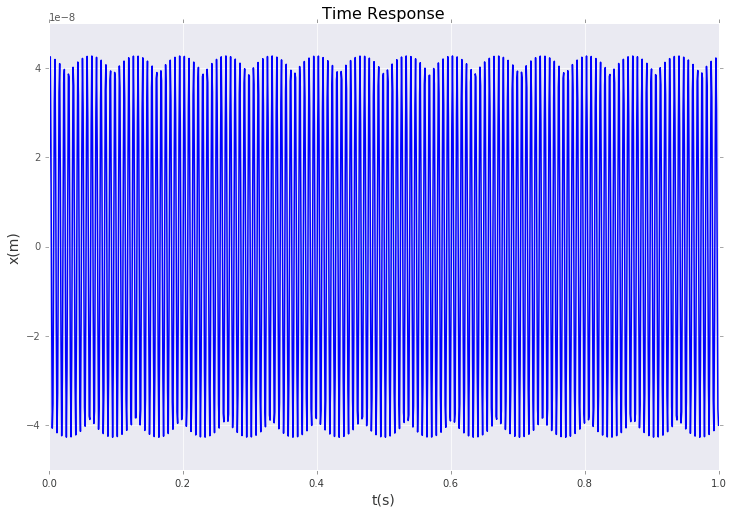

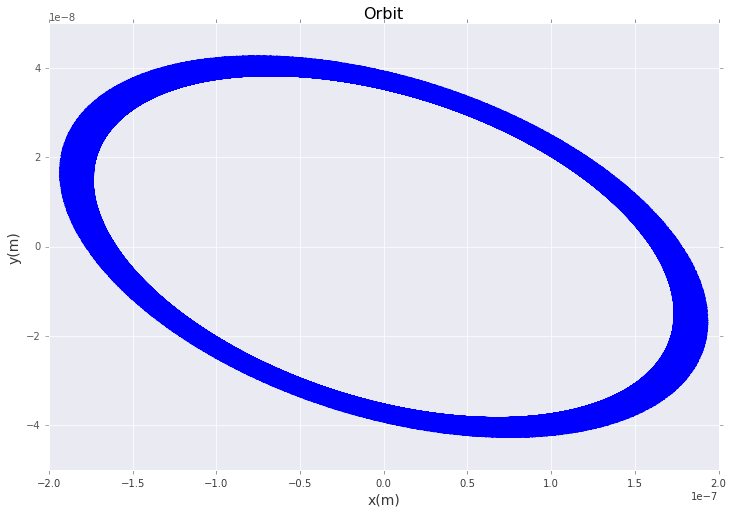

In [56]:
#plot da resposta do tempo e órbita
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
plt.plot(t, sol3[0:1000,1:2],'b')
xlabel('t(s)',fontsize=14)
ylabel('x(m)',fontsize=14)
plt.title('Time Response', fontsize = 16)
plt.figure()
ylabel('y(m)',fontsize=14)
xlabel('x(m)',fontsize=14)
plt.title('Orbit', fontsize = 16)
plt.plot(sol3[10:1000,0:1], sol3[10:1000,1:2],'b')

In [17]:
def Freq_Response_v2(rot,pos,q):    # função para FRF
    dist=1e-3
    ang=0.000290888*10
    
    X=[]# vetores que serão preenchidos
    
    Y=[]
    Alfa=[]
    Beta=[]
    
    amp=[]
    resp=np.array([])
    
    for i in rot:
        F1=np.array([])
        
        
        M1 = rotor_bal.M()
        K1 = rotor_bal.K(w=i)
        C1 = rotor_bal.C(w=i)
        G1 = rotor_bal.G()
        A1 = -i**2*M1+1j*i*(C1+G1)+K1
        
        for no in np.linspace(0,q,q+1):
            
            f1 = np.array([rotor_bal.M()[no*4:no*4+4,no*4:no*4+4][0][0]*dist*i**2, 
                           rotor_bal.M()[no*4:no*4+4,no*4:no*4+4][1][1]*dist*i**2,
                           (rotor_bal.M()[no*4:no*4+4,no*4:no*4+4][2][2]-rotor_bal.G()[no*4:no*4+4,no*4:no*4+4][2][3])*ang*i**2,#1,
                           (rotor_bal.M()[no*4:no*4+4,no*4:no*4+4][3][3]-rotor_bal.G()[no*4:no*4+4,no*4:no*4+4][2][3])*ang*i**2])#1])
            
            
            
            F1=np.hstack((F1, np.transpose(f1)))
             
              
        Ar  = linalg.inv(A1) @ F1
        #amp=np.hstack((amp, Ar))
        amp+= [Ar]
    amp=np.asarray(amp)
    
    a=0
    for no in np.linspace(0,q,q+1):
            vet=amp[0:len(rot),4*no + pos:4*no + pos + 1].T
            vet=np.asarray(vet)
            
            
            
            if len(resp)!=0:
                resp=np.vstack((resp,vet))
            else:
                
                resp=np.append(resp,vet)
            
            
            
            
        
    
    return resp
    

In [18]:
rot=np.linspace(0,5000,500) #vetor rotação que vai analisar a FRF
Amp=Freq_Response_v2(rot,0,21)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


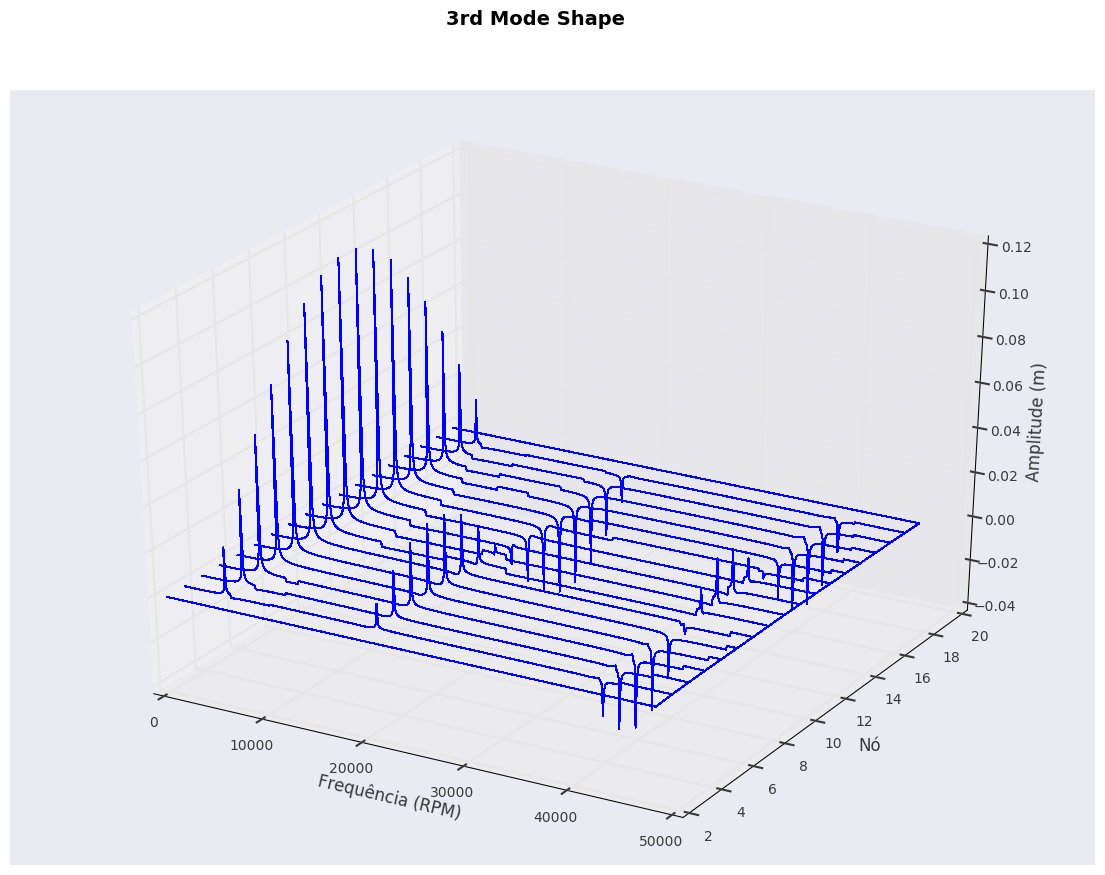

In [21]:

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)
q=20 # índice do último nó


Amp1=Amp[2:q,0:len(rot)]
T=(60/(2*np.pi))*rot
z=np.arange(2,q)
sx = T.size
sy = z.size
T = np.tile(T, (sy, 1))
z = np.tile(z, (sx, 1)).T

U = Amp1


fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
surf = ax.plot_wireframe(T, z, -abs(U)*(U.imag/abs(U.imag)),rstride=1,cstride=1000,lw=.75, antialiased=False) # Plot 3D da FRF, onde ''-abs(U)*(U.imag/abs(U.imag) '' é usado paramultiplicar o módulo da FRF apenas pelo sinal da Fase.


#ax.view_init(0, 180) #comando para rotacionar a figura
plt.yticks(fontsize=10)
ax.tick_params(axis='z', labelsize=10)


fig.suptitle('3rd Mode Shape', fontsize=14, fontweight='bold')

ax.set_xlabel('Frequência (RPM)')
ax.set_ylabel('Nó')
ax.set_zlabel('Amplitude (m)')

plt.show(surf)
